In [1]:
# import package
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import random
import copy
import pickle
import bisect

from zipfile import ZipFile
import os
import math
from datetime import *
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, SelectKBest


# load tools
sys.path.append("../tool/")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from imp import reload
import preprocess
import evaluation
import buildmodel

In [3]:
# load the data
raw_train_data = preprocess.load_data("../data/rossmann_store_sales/", "train.csv", 
                       dtype={"StateHoliday":"category",
                             "SchoolHoliday":"uint8",
                             "Promo":"uint8",
                             "Promo2":"category"},
                       converters={"Date":lambda x: pd.to_datetime(x, errors="raise")})

raw_store_data = preprocess.load_data("../data/rossmann_store_sales/", "store.csv")

raw_test_data = preprocess.load_data("../data/rossmann_store_sales/", "test.csv",
                     dtype={"StateHoliday":"category",
                             "SchoolHoliday":"uint8",
                             "Promo":"uint8",
                             "Promo2":"category"},
                       converters={"Date":lambda x: pd.to_datetime(x, errors="raise")})

predict_template = preprocess.load_data("../data/rossmann_store_sales/", "sample_submission.csv")

### preprocess data

对数据进行处理，分别获取到具有重复信息的features—— dumplicate_features，另外获取到了创建的新 features ——new_features

In [5]:
all_data, dulicate_features = preprocess.collect_data(raw_train_data.copy(), raw_test_data.copy(), raw_store_data.copy())

C:\Users\ren-r\Anaconda3\lib\site-packages\pandas\core\generic.py:5817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [7]:
new_all_data, new_features = preprocess.extend_features(all_data.copy())

### 建立模型
需要先从特征选择开始，之后尝试调整参数

**为了避免训练数据集中使用到未来预测的时间上的数据集而出现问题，特意不使用 train_test_split 方法来区分数据集**

In [ ]:
# splite the train data into train_data and validate_data
Xtrain, Xvalidate, ytrain, yvalidate = train_test_split(new_all_data.query("Tag=='train'").copy(), 
                                                        new_all_data.query("Tag=='train'").copy()["SalesByLog"], 
                                                        test_size=0.35, random_state=42,
                                                       shuffle=True)
Xtest = new_all_data.query("Tag=='test'").copy()

In [8]:
# fill the missing value in the field SalesByLog
new_all_data.SalesByLog.fillna(0, inplace=True)

In [9]:
# select the specific date to train the model by using the date of test data
maxdate = new_all_data.query("Tag == 'train'").Date.max()
datedelta = raw_test_data.Date.max() - raw_test_data.Date.min()
mindate = maxdate - datedelta

In [10]:
# split the data into train, validate and test
validate_index = new_all_data.query("Tag == 'train'").Date.apply(lambda x: x in pd.date_range(mindate, maxdate))

Xvalidate = new_all_data.query("Tag == 'train'")[validate_index].copy()
yvalidate = Xvalidate.SalesByLog

Xtrain = new_all_data.query("Tag == 'train'")[~validate_index].copy()
ytrain = Xtrain.SalesByLog

Xtest = new_all_data.query("Tag == 'test'").copy()

## 基本训练

**前期已经验证过那些 features 可以使用，需要的是确立最终的模型。所以不再进行特征筛选**

In [11]:
# train features
features = [
    'Open',
     'Assortment_a',
     'Assortment_b',
     'CompetitionDistance',
     'CompetitionOpenMonths',
     'CompetitionOpenSinceMonth',
     'CompetitionOpenSinceYear',
     'DayOfWeek_1',
     'DayOfWeek_2',
     'DayOfWeek_3',
     'DayOfWeek_4',
     'DayOfWeek_5',
     'DayOfWeek_6',
     'InPromo2',
     'OpenDayOfMonth',
     'OpenDayOfYear',
     'OpenMonth',
     'OpenWeekOfYear',
     'OpenYear',
     'Promo',
     'Promo2SinceWeek',
     'Promo2SinceYear',
     'SchoolHoliday',
     'StateHoliday_Public',
     'Store',
     'StoreType_a',
     'StoreType_b',
     'StoreType_c',
     'AvgSales',
     'AvgCustomers',
     'AvgSalesPerCustomers',
     'MedianCustomers',
     'HolidayThisWeek',
     'HolidayNextWeek',
     'HolidayLastWeek',
     'AvgSalesInDayOfWeek',
     'MedianSalesInDayOfWeek',
     'AvgCustsInDayOfWeek',
     'MedianCustsInDayOfWeek'
]

In [12]:
params = {'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'silent': 1,
     'seed': 1301,
    "lambda": .2,
         }


dtrain = buildmodel.xgb_dmatrix(Xtrain, features, "SalesByLog", missing=np.nan)
dvalidate = buildmodel.xgb_dmatrix(Xvalidate, features, "SalesByLog", missing=np.nan)
dtest = xgb.DMatrix(Xtest[features])

evallist = [(dvalidate, "eval"), (dtrain, "train")]

**这里是对前面确定的最佳模型进行一次测试结果**

In [12]:
# update the parameters
params["max_depth"] = 16
params["subsample"] = 0.6
params["colsample_bytree"] = 0.4
params["lambda"] = 0.2
params["gamma"] = 0

# train the final model
model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=14000, 
                       evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=2000)
validate_score = evaluation.rmspe(yvalidate, model.predict(dvalidate))


print("="*60+"{0:=<60}".format("Current train is done!"))

[0]	eval-rmse:8.21715	train-rmse:8.18427	eval-RMSPE:14.099	train-RMSPE:14.0417
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[2000]	eval-rmse:0.109563	train-rmse:0.054309	eval-RMSPE:0.012569	train-RMSPE:0.006318
[4000]	eval-rmse:0.109892	train-rmse:0.041444	eval-RMSPE:0.012613	train-RMSPE:0.004819
[6000]	eval-rmse:0.110693	train-rmse:0.032571	eval-RMSPE:0.012709	train-RMSPE:0.003783
[8000]	eval-rmse:0.111432	train-rmse:0.026106	eval-RMSPE:0.012795	train-RMSPE:0.003028
[10000]	eval-rmse:0.112109	train-rmse:0.02118	eval-RMSPE:0.012874	train-RMSPE:0.002454
[12000]	eval-rmse:0.112641	train-rmse:0.017268	eval-RMSPE:0.012935	train-RMSPE:0.001999
[13999]	eval-rmse:0.113033	train-rmse:0.014248	eval-RMSPE:0.01298	train-RMSPE:0.001648
============================================================Current train is done!======================================


**上面的结果得到的结果分数值降低了了，但是 public 分数值升高了；下面重新测试**

In [13]:
# train model
tree_params = []


for md in range(9, 17):
    for ss in [6, 8]:
        for colst in [4, 5, 6]:
            for lmd in [0.1, 0.2]:
                    
                    params["max_depth"] = md
                    params["subsample"] = ss / 10
                    params["colsample_bytree"] = colst / 10
                    params["lambda"] = lmd
                    params["gamma"] = 0

                    print("The max_depth is %f, subsample is %f,colsample_bytree is %f, lambda is %f.\n" % (md, ss/10, colst/10, lmd))

                    model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=3000, 
                                           evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=1500)
                    validate_score = evaluation.rmspe(yvalidate, model.predict(dvalidate))
                    tree_params.append((copy.deepcopy(params), validate_score))
                    
                    predict_values = model.predict(dtest)
                    predict_csv = evaluation.get_result(predict_values, Xtest, 
                                                        "../output/prediction/test/", "fix{0}_{1}_{2}{3}_second.csv".format(md, ss, colst, lmd))

                    print("="*60+"{0:=<20}.The score is {1:<10}".format("Current train is done!", validate_score))

The max_depth is 9.000000, subsample is 0.600000,colsample_bytree is 0.400000, lambda is 0.100000.

[0]	eval-rmse:8.21706	train-rmse:8.18427	eval-RMSPE:14.0968	train-RMSPE:14.0416
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.11789	train-rmse:0.095975	eval-RMSPE:0.013523	train-RMSPE:0.011111
[2999]	eval-rmse:0.114417	train-rmse:0.087834	eval-RMSPE:0.013124	train-RMSPE:0.010169
============================================================Current train is done!.The score is 0.013108861277897206
The max_depth is 9.000000, subsample is 0.600000,colsample_bytree is 0.400000, lambda is 0.200000.

[0]	eval-rmse:8.21712	train-rmse:8.18427	eval-RMSPE:14.0985	train-RMSPE:14.0417
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.11771	train-rmse:0.096212	eval-RMSP

Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.115379	train-rmse:0.09051	eval-RMSPE:0.013232	train-RMSPE:0.010481
[2999]	eval-rmse:0.111899	train-rmse:0.081956	eval-RMSPE:0.012834	train-RMSPE:0.009492
============================================================Current train is done!.The score is 0.0128238713062814
The max_depth is 10.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.100000.

[0]	eval-rmse:8.21715	train-rmse:8.18427	eval-RMSPE:14.099	train-RMSPE:14.0415
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.115183	train-rmse:0.089524	eval-RMSPE:0.013215	train-RMSPE:0.010368
[2999]	eval-rmse:0.112209	train-rmse:0.080777	eval-RMSPE:0.012875	train-RMSPE:0.009356
============================================================Cu

[1500]	eval-rmse:0.113517	train-rmse:0.083666	eval-RMSPE:0.013018	train-RMSPE:0.009694
[2999]	eval-rmse:0.110846	train-rmse:0.074597	eval-RMSPE:0.012716	train-RMSPE:0.008645
============================================================Current train is done!.The score is 0.012731054404588767
The max_depth is 11.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.200000.

[0]	eval-rmse:8.21714	train-rmse:8.18427	eval-RMSPE:14.0988	train-RMSPE:14.0416
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.113325	train-rmse:0.084158	eval-RMSPE:0.013	train-RMSPE:0.009751
[2999]	eval-rmse:0.110479	train-rmse:0.074939	eval-RMSPE:0.012675	train-RMSPE:0.008684
============================================================Current train is done!.The score is 0.012681172927359168
The max_depth is 11.000000, subsample is 0.600000,colsample_bytree is 0.600000, lambda is 0.

============================================================Current train is done!.The score is 0.012600719862733277
The max_depth is 12.000000, subsample is 0.600000,colsample_bytree is 0.600000, lambda is 0.100000.

[0]	eval-rmse:8.21706	train-rmse:8.18427	eval-RMSPE:14.0968	train-RMSPE:14.0414
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.112914	train-rmse:0.077794	eval-RMSPE:0.012947	train-RMSPE:0.00902
[2999]	eval-rmse:0.110779	train-rmse:0.06789	eval-RMSPE:0.012705	train-RMSPE:0.007873
============================================================Current train is done!.The score is 0.012735740697436807
The max_depth is 12.000000, subsample is 0.600000,colsample_bytree is 0.600000, lambda is 0.200000.

[0]	eval-rmse:8.21704	train-rmse:8.18427	eval-RMSPE:14.0963	train-RMSPE:14.0416
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stoppin

[0]	eval-rmse:8.21704	train-rmse:8.18427	eval-RMSPE:14.0963	train-RMSPE:14.0416
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.11153	train-rmse:0.072773	eval-RMSPE:0.01279	train-RMSPE:0.008443
[2999]	eval-rmse:0.109992	train-rmse:0.062023	eval-RMSPE:0.012617	train-RMSPE:0.007197
============================================================Current train is done!.The score is 0.012654837264754628
The max_depth is 13.000000, subsample is 0.800000,colsample_bytree is 0.400000, lambda is 0.100000.

[0]	eval-rmse:8.21718	train-rmse:8.18427	eval-RMSPE:14.0999	train-RMSPE:14.0415
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.110832	train-rmse:0.070906	eval-RMSPE:0.012711	train-RMSPE:0.008231
[2999]	eval-rmse:0.109629	train-rmse:0.060619	eval-RMSPE:0.012577	t

KeyboardInterrupt: 

**目前已经确定了一个最有值，重新构建图形**

In [14]:
params["max_depth"] = 14
params["subsample"] = 0.6
params["colsample_bytree"] = 0.4
params["lambda"] = 0.1
model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=3000, 
                                           evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=1500)

[0]	eval-rmse:8.21716	train-rmse:8.18427	eval-RMSPE:14.0993	train-RMSPE:14.0415
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1500]	eval-rmse:0.109904	train-rmse:0.06786	eval-RMSPE:0.012602	train-RMSPE:0.007881
[2999]	eval-rmse:0.108841	train-rmse:0.057585	eval-RMSPE:0.012486	train-RMSPE:0.006689


**保存相关模型**

In [27]:
buildmodel.down_model(model, features, "../output/feature/roundfix01.txt", "../output/model/roundfix01.model")

**下面的 predict 数据使用新的检验数据**

In [15]:
Xpredict = Xvalidate.copy()
dpredict = buildmodel.xgb_dmatrix(Xpredict, features, "SalesByLog", missing=np.nan)

In [16]:
validate_value = model.predict(dpredict)
# predict_csv = evaluation.get_result(predict_values, Xtest, 
#                                     "../output/prediction/test/", "{0}_{1}_{2}{3}.csv")

In [17]:
Xpredict["SalesPredicted"] = np.expm1(validate_value)
Xpredict["SalesDifference"] = Xpredict["Sales"] - Xpredict["SalesPredicted"]
Xpredict["RMSPE_score"] = Xpredict["SalesDifference"] / Xpredict["Sales"]

In [18]:
Xpredict.sort_values(by="Date", inplace=True)

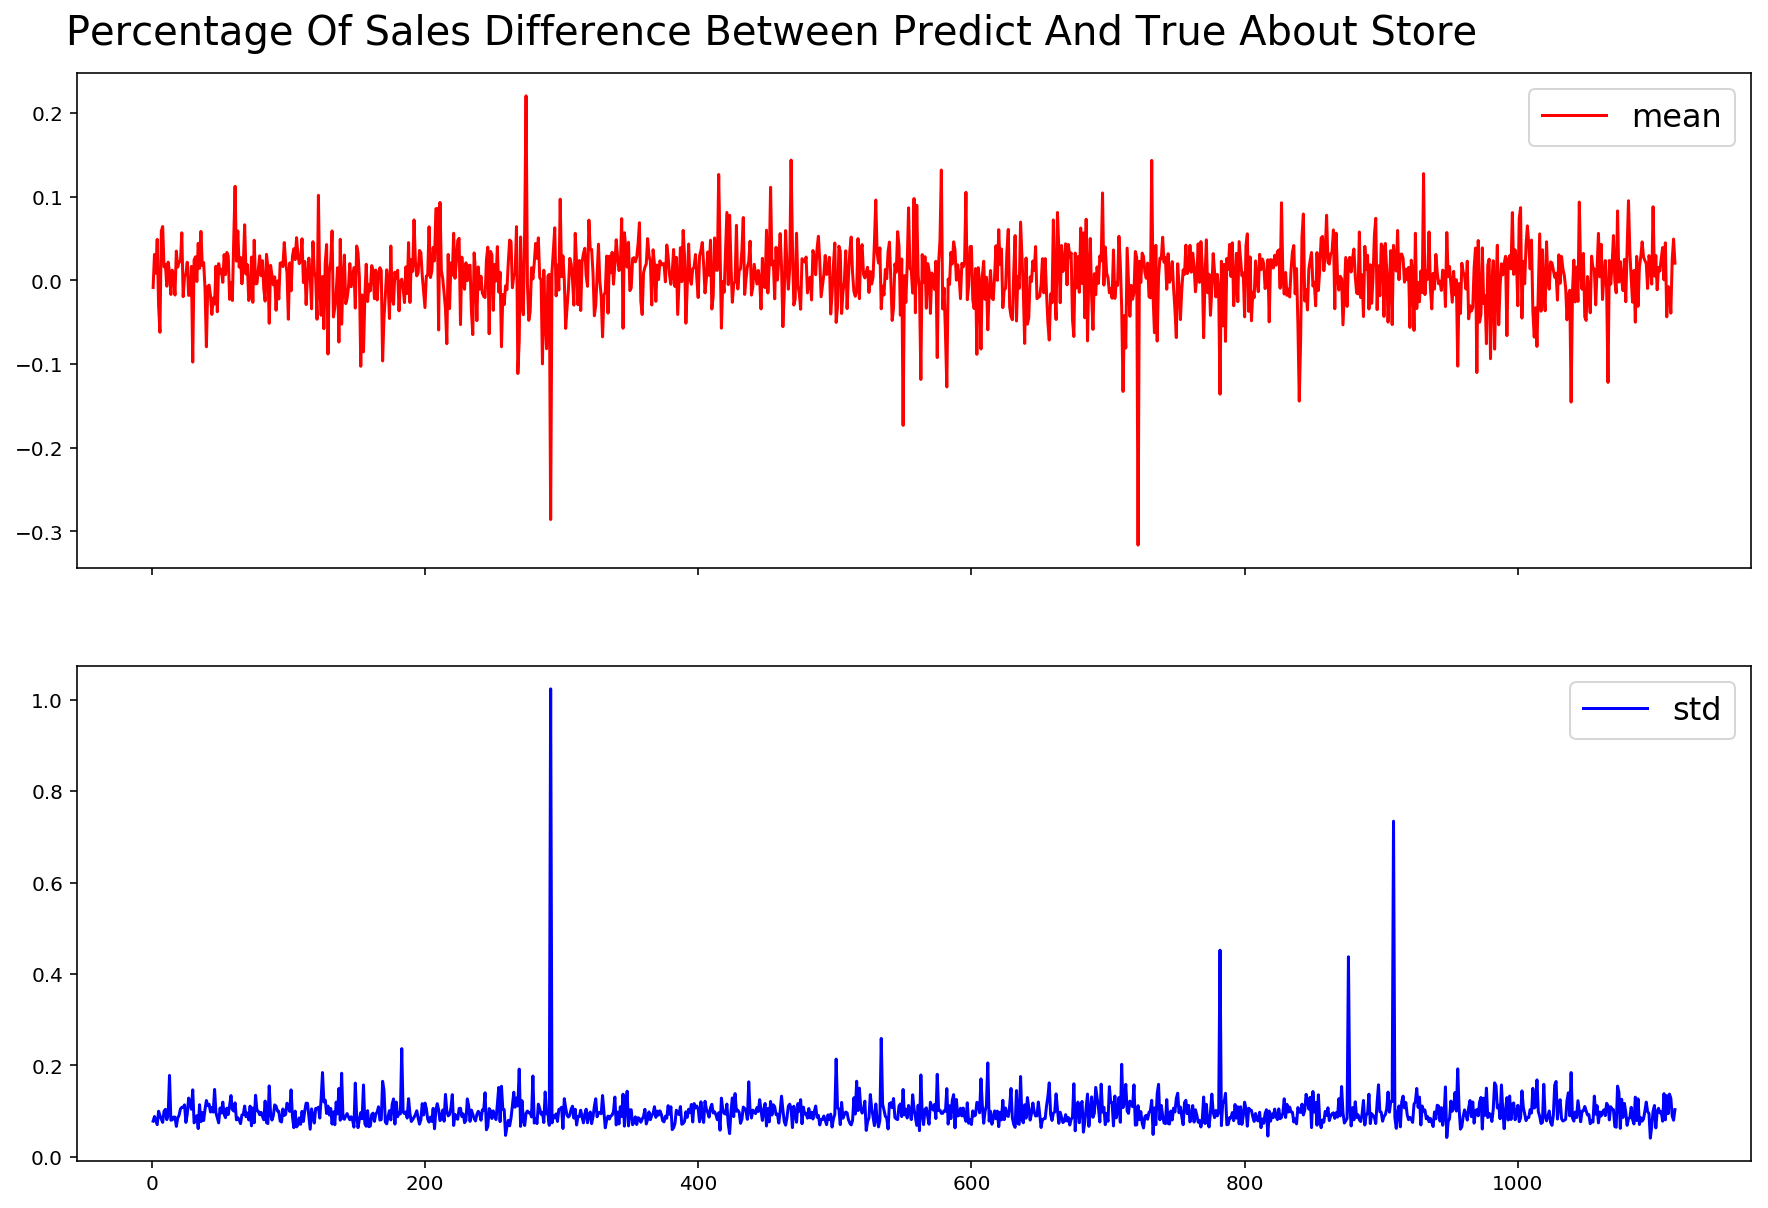

In [19]:
Xpredict["RMSPE_score"] = Xpredict["SalesDifference"] / Xpredict["Sales"]
mean = Xpredict.groupby("Store").RMSPE_score.mean()
std = Xpredict.groupby("Store").RMSPE_score.std()
# mean = pd.DataFrame(mean.apply(abs))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

# plt.title("Percentage Of Sales Difference Between Predict And True" )
plot_mean = ax1.plot(mean.index, mean.values, "r")
plot_std = ax2.plot(std.index, std.values, "b")
# ax1.title.draw(pttext.Text(0.5, 1, "Percentage Of Sales Difference Between Predict And True"))
fig.text(0.12, 0.9, "Percentage Of Sales Difference Between Predict And True About Store", fontsize=20)
ax1.legend(["mean"],fontsize=16)
ax2.legend(["std"], fontsize=16)

plt.show()

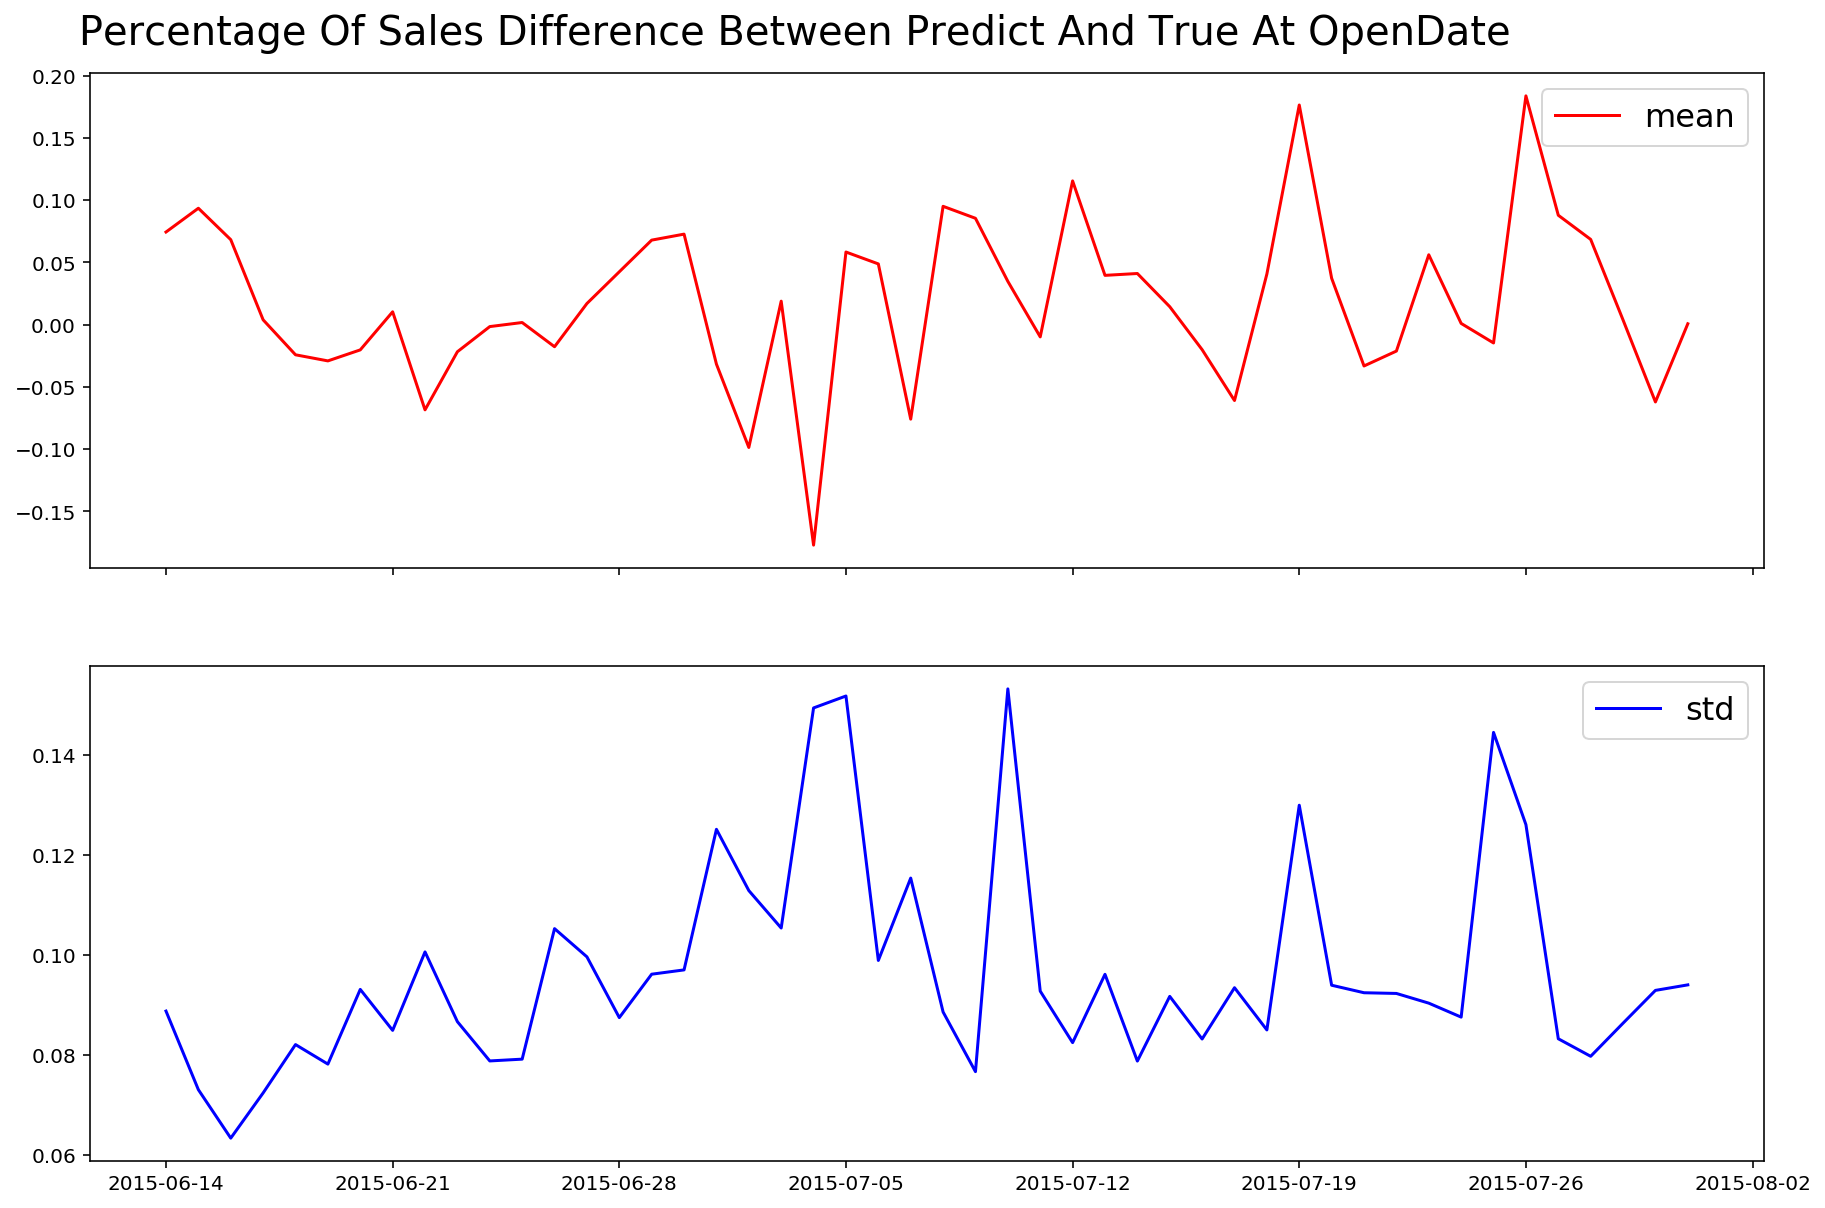

In [20]:
mean = Xpredict.groupby("Date").RMSPE_score.mean()
std = Xpredict.groupby("Date").RMSPE_score.std()
# mean = pd.DataFrame(mean.apply(abs))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

# plt.title("Percentage Of Sales Difference Between Predict And True" )
plot_mean = ax1.plot(mean.index, mean.values, "r")
plot_std = ax2.plot(std.index, std.values, "b")
# ax1.title.draw(pttext.Text(0.5, 1, "Percentage Of Sales Difference Between Predict And True"))
fig.text(0.12, 0.9, "Percentage Of Sales Difference Between Predict And True At OpenDate", fontsize=20)
ax1.legend(["mean"],fontsize=16)
ax2.legend(["std"], fontsize=16)

plt.show()

In [21]:
mean = Xpredict.groupby("Store").RMSPE_score.mean()
std = Xpredict.groupby("Store").RMSPE_score.std()
mean.idxmax(), std.idxmax()

(274, 292)

### 探索到的新店铺号数

In [22]:
store_name = Xpredict.query("Store == 274").copy()

test_1 = store_name[["Date", "Sales"]].copy()
test_1["Type"] = "Real Sales"

test_2 = store_name[["Date", "SalesPredicted"]].copy()
test_2.columns = ["Date", "Sales"]
test_2["Type"] = "Predict Sales"
store_name = pd.concat([test_1, test_2])
store_name.Date = store_name.Date.dt.strftime("%y-%m-%d")

In [23]:
dateindex = []
for index, dt in enumerate(store_name.Date):
    if index % 4 == 0:
        dateindex.append(dt)


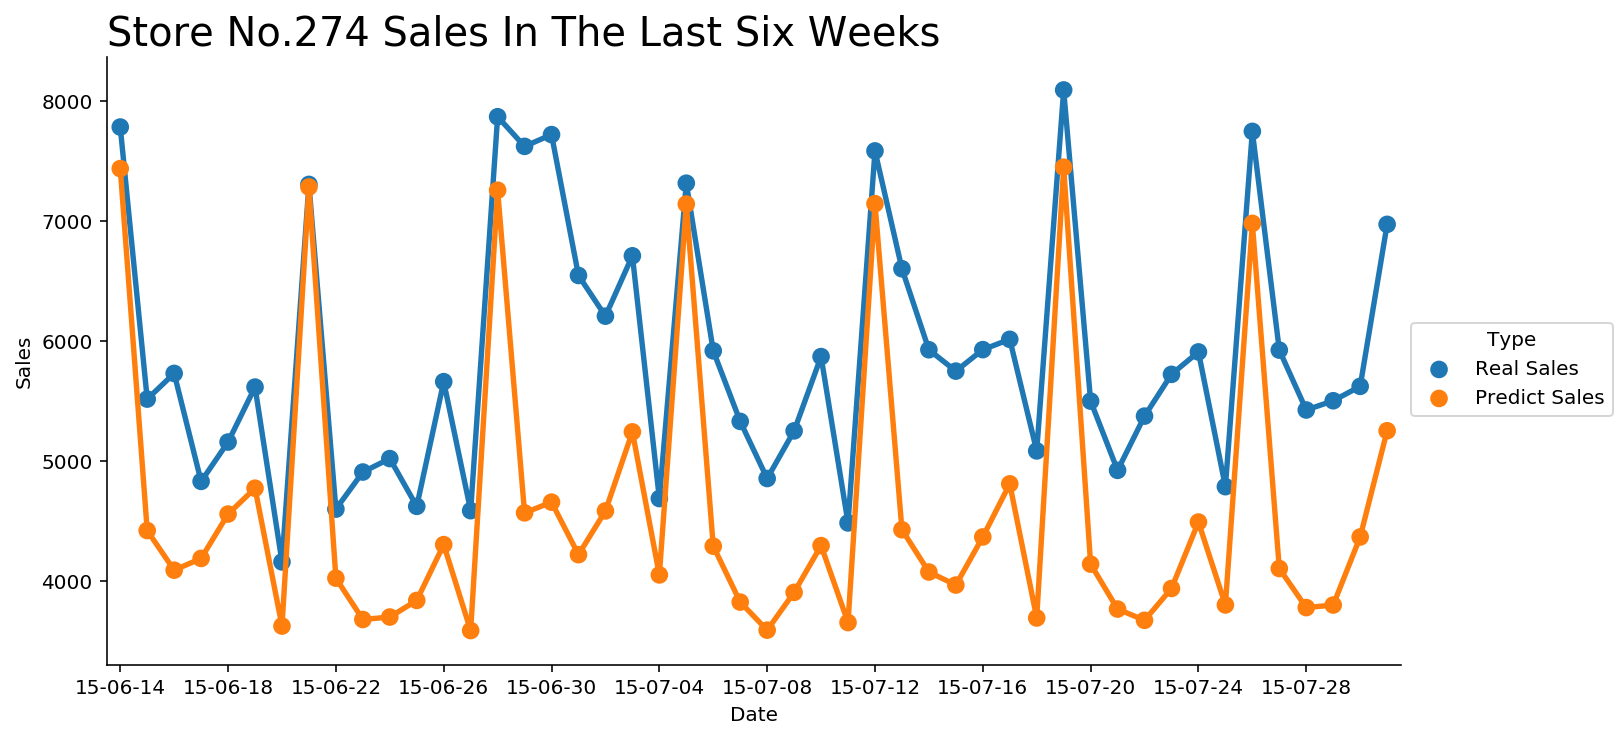

In [24]:
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="Date", y="Sales", hue="Type", data=store_name,size=5,aspect=2)
g.set_axis_labels("Date", "Sales")

# g.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Store No.274 Sales In The Last Six Weeks", loc="left", fontsize=20)
ax = plt.gca()
ax.set_xticks(range(0, 48, 4))
ax.set_xticklabels(dateindex)
# ax.
plt.show()

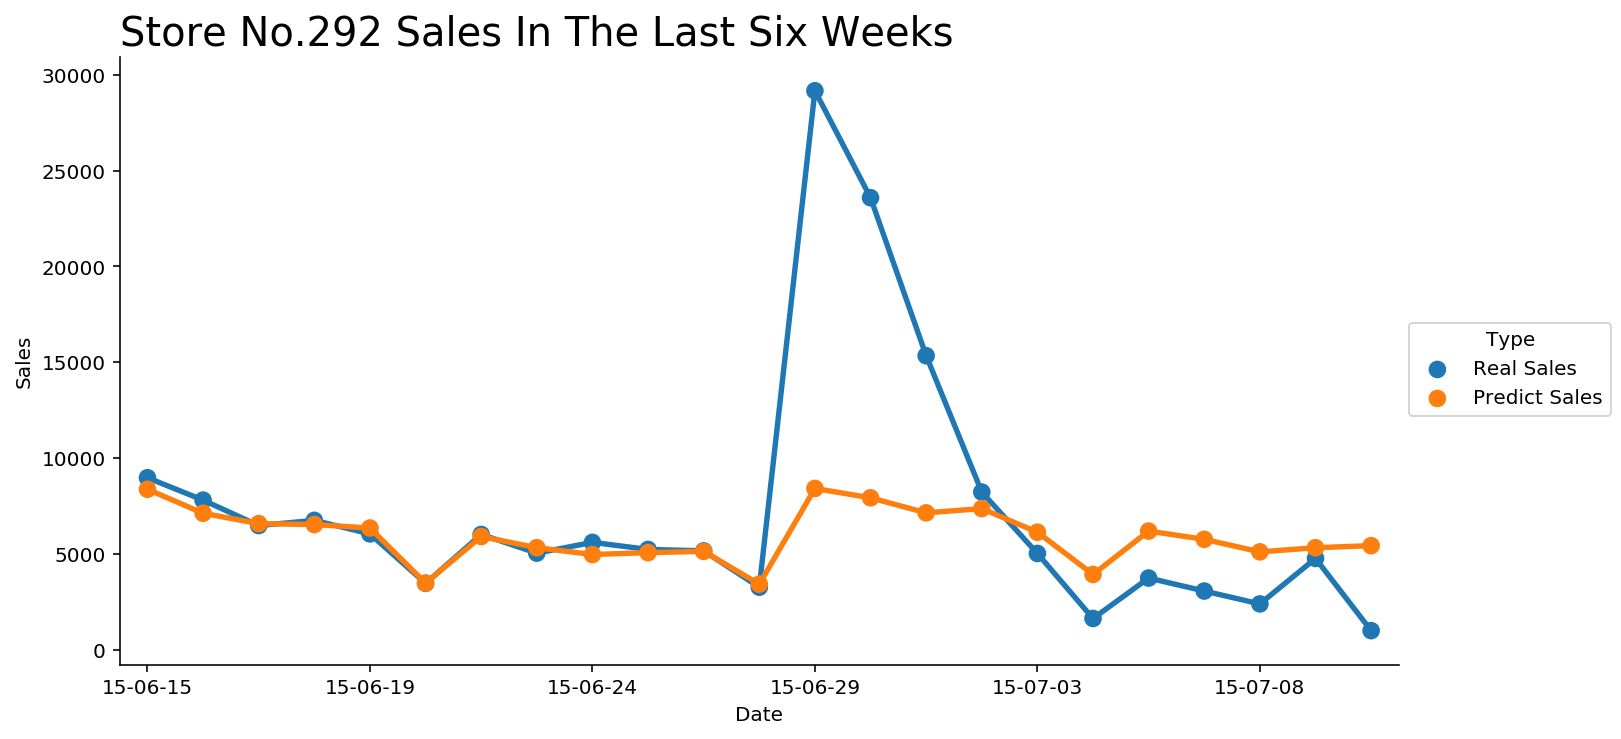

In [25]:
store_name = Xpredict.query("Store == 292").copy()

test_1 = store_name[["Date", "Sales"]].copy()
test_1["Type"] = "Real Sales"

test_2 = store_name[["Date", "SalesPredicted"]].copy()
test_2.columns = ["Date", "Sales"]
test_2["Type"] = "Predict Sales"
store_name = pd.concat([test_1, test_2])
store_name.Date = store_name.Date.dt.strftime("%y-%m-%d")

dateindex = []
for index, dt in enumerate(store_name.Date):
    if index % 4 == 0:
        dateindex.append(dt)

plt.figure(figsize=(15, 7))
g = sns.factorplot(x="Date", y="Sales", hue="Type", data=store_name,size=5,aspect=2)
g.set_axis_labels("Date", "Sales")

# g.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Store No.292 Sales In The Last Six Weeks", loc="left", fontsize=20)
ax = plt.gca()
ax.set_xticks(range(0, 24, 4))
ax.set_xticklabels(dateindex)
# ax.
plt.show()